# 거시경제 시뮬레이션 분석
1. 데이터 정규화
2. 변수 간 상관관계 분석 및 예측 모델에 포함할 변수 선정
3. 단위근 검정을 통한 시계열 안정성 확인 및 필요시 차분 변환
4. AIC/BIC를 활용한 최적 VAR 랙 수 결정
5. VAR 모델 잔차 분석을 통한 모델 적합성 검증
6. Proxy와 GDP 간의 관계를 분석하여 Laffer Curve 피팅
7. 정책 결정에 활용할 기준값(최적 AI 세율) 산출

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.optimize import curve_fit
import warnings
from statsmodels.stats.diagnostic import acorr_ljungbox

In [104]:
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [105]:
data = pd.read_csv("../data/master_data_by_category_clear.csv")

## 1. 상관관계 분석
- 정규화된 데이터(num_cols)를 대상으로 상관관계 행렬을 계산 및 시각화화

In [106]:
num_cols = [col for col in data.select_dtypes(include=[np.number]).columns if col not in ["Year"]]
data_norm = data.copy()
data_norm[num_cols] = StandardScaler().fit_transform(data[num_cols])
print("정규화된 데이터 (Country와 Year 제외):")
print(data_norm.head())

정규화된 데이터 (Country와 Year 제외):
  Country  Year  Business sophistication  Corporate Tax  Creative outputs  \
0   China  2013                -1.950787      -0.585282         -2.505825   
1   China  2014                -2.173025      -0.585282         -1.914020   
2   China  2015                -1.546718      -0.585282         -2.007463   
3   China  2016                 0.251389      -0.585282         -0.823854   
4   China  2017                 0.392813      -0.585282         -0.418935   

        GDP  GDP_per_capita_PPP      GERD  GNI_per_capita  General Revenue  \
0  0.367612           -2.295876 -1.254855       -2.152596        -1.937789   
1  0.502676           -2.251198 -1.222785       -2.104493        -1.414625   
2  0.590120           -2.220536 -1.177494       -2.076817        -1.390436   
3  0.615741           -2.177473 -1.120816       -2.055731        -1.434887   
4  0.776481           -2.121600 -1.100265       -2.025420        -1.407631   

   Global Innovation Index  Human capit

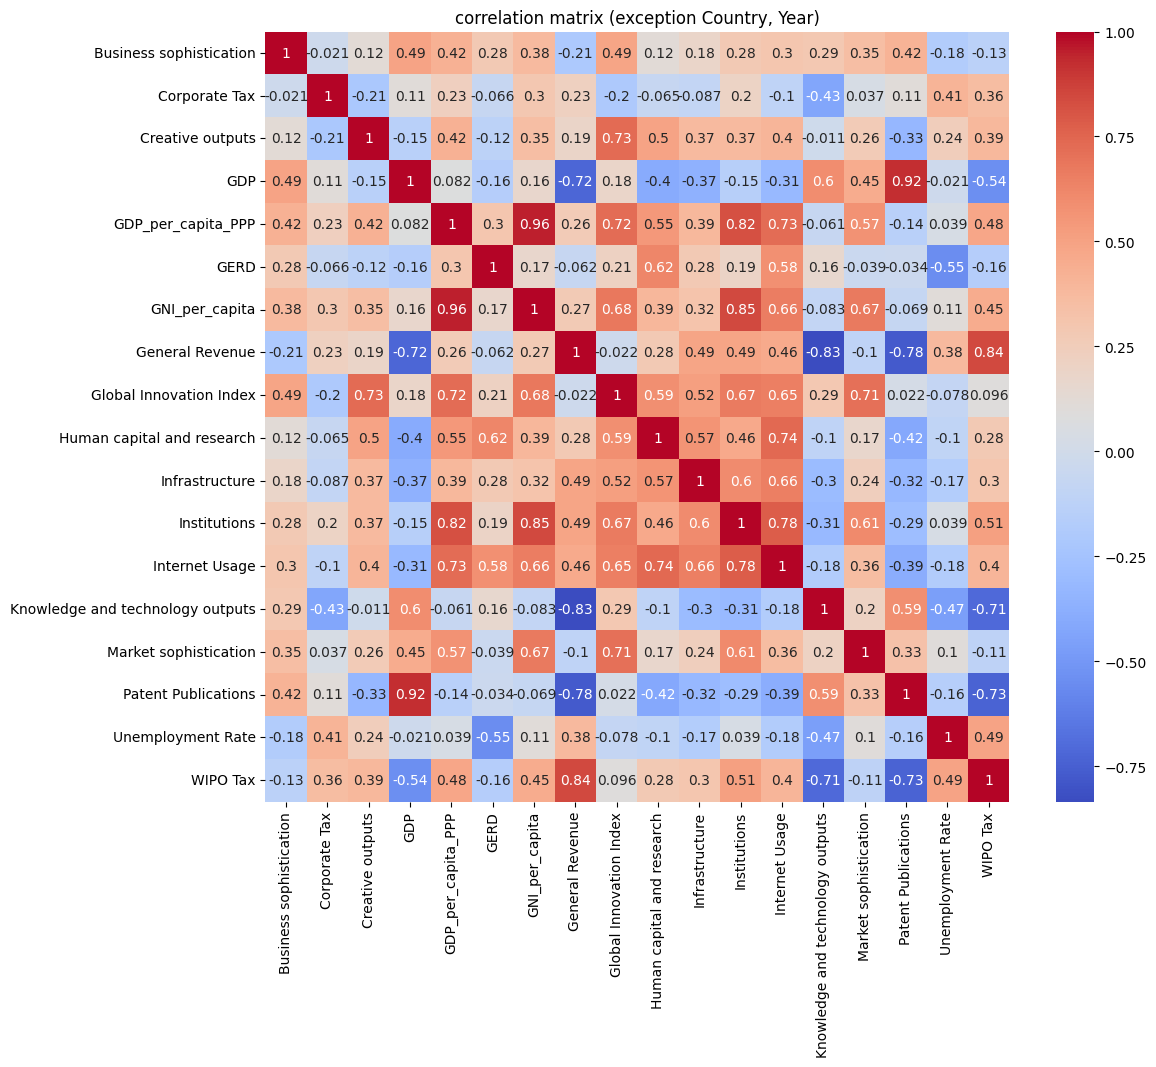

In [107]:
corr_matrix = data_norm[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("correlation matrix (exception Country, Year)")
plt.show()

In [108]:
threshold = 0.45
gdp_corr = corr_matrix["GDP"].abs()
selected_vars = gdp_corr[gdp_corr >= threshold].index.tolist()
print("GDP와 상관계수", threshold, "이상인 변수들:", selected_vars)

GDP와 상관계수 0.45 이상인 변수들: ['Business sophistication', 'GDP', 'General Revenue', 'Knowledge and technology outputs', 'Patent Publications', 'WIPO Tax']


## 2. 단위근 검정 (ADF Test) 및 차분
- GDP와의 상관계수가 0.45 이상인 변수를 선택하고, 각 변수에 대해 ADF 테스트를 수행하여 비정상적이면 1차 차분을 적용  
- 차분된 데이터: `differenced_data` 딕셔너리에 저장

In [109]:
def adf_test(series, var_name):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"ADF Test for {var_name}: Test Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")
    return result[1]

differenced_data = {}

In [110]:
for var in selected_vars:
    p_val = adf_test(data_norm[var], var)
    if p_val > 0.05:
        diff_series = data_norm[var].diff()
        differenced_data[var] = diff_series
    else:
        print(f"{var}는 정상입니다.")

ADF Test for Business sophistication: Test Statistic = -3.2664, p-value = 0.0164
Business sophistication는 정상입니다.
ADF Test for GDP: Test Statistic = -0.3652, p-value = 0.9157
ADF Test for General Revenue: Test Statistic = -1.4295, p-value = 0.5681
ADF Test for Knowledge and technology outputs: Test Statistic = -2.7370, p-value = 0.0678
ADF Test for Patent Publications: Test Statistic = -1.6495, p-value = 0.4573
ADF Test for WIPO Tax: Test Statistic = -2.3427, p-value = 0.1586


In [111]:
if differenced_data:
    diff_df = pd.DataFrame(differenced_data)
    diff_df = diff_df.dropna()
    print("\n1차 차분된 데이터 (NaN 제거 후):")
    print(diff_df)


1차 차분된 데이터 (NaN 제거 후):
         GDP  General Revenue  Knowledge and technology outputs  \
1   0.135064         0.523164                          0.507461   
2   0.087443         0.024189                         -0.195177   
3   0.025621        -0.044451                         -0.917332   
4   0.160741         0.027256                          0.605049   
5   0.236425         0.070232                          0.019518   
..       ...              ...                               ...   
65  0.155846        -0.186163                          0.234213   
66  0.131837        -0.020294                          0.800226   
67 -0.027740         0.049024                         -0.566014   
68  0.347252         0.098306                          0.468425   
69  0.347043         0.076172                          0.312283   

    Patent Publications  WIPO Tax  
1              0.230780 -0.014769  
2              0.290733 -0.046365  
3              0.164491 -0.081229  
4              0.487840 -0.

## 3. VAR 모델 최적 Lag 수 결정
- 차분된 데이터(diff_df)를 사용하여 VAR 모델을 피팅하고, AIC와 BIC 기준으로 최적의 랙 수를 결정

In [112]:

var_model = VAR(diff_df)
lag_order_results = var_model.select_order(maxlags=10)
print("\n최적 Lag 수 (AIC):", lag_order_results.aic)
print("최적 Lag 수 (BIC):", lag_order_results.bic)
optimal_lag = lag_order_results.aic
var_fitted = var_model.fit(optimal_lag)
print("\nVAR 모델 요약:")
print(var_fitted.summary())


최적 Lag 수 (AIC): 10
최적 Lag 수 (BIC): 0

VAR 모델 요약:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 16, Mar, 2025
Time:                     18:51:04
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -9.85839
Nobs:                     59.0000    HQIC:                  -15.3325
Log likelihood:           392.122    FPE:                5.70673e-07
AIC:                     -18.8376    Det(Omega_mle):     2.53328e-08
--------------------------------------------------------------------
Results for equation GDP
                                          coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------------------
const                                        0.037616         0.035737            1.053           0.293
L1.GDP                  

c:\workspace\2025oss-couscous\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


## 4. VAR 모델 잔차 분석
- Ljung-Box 검정을 통해 모델 잔차의 백색잡음 여부를 확인합니다.

In [113]:
lb_results = {}
for col in var_fitted.resid.columns:
    lb = acorr_ljungbox(var_fitted.resid[col], lags=[optimal_lag], return_df=True)
    lb_results[col] = lb
print("\nLjung-Box test 결과 (각 변수별):")
for col, res in lb_results.items():
    print(f"\n{col}:")
    print(res)


Ljung-Box test 결과 (각 변수별):

GDP:
      lb_stat  lb_pvalue
10  26.269814   0.003394

General Revenue:
      lb_stat  lb_pvalue
10  18.305688   0.050021

Knowledge and technology outputs:
      lb_stat  lb_pvalue
10  18.707072   0.044145

Patent Publications:
      lb_stat  lb_pvalue
10  20.653003   0.023647

WIPO Tax:
      lb_stat  lb_pvalue
10  11.467383   0.322282


## 5. Proxy 변수 선택 및 Laffer Curve 피팅
- GDP와 높은 상관관계를 가진 변수들 중 GDP를 제외한 변수를 Proxy 후보로 선정
- 해당 Proxy와 GDP 간의 관계를 Laffer Curve (이차함수)로 피팅하여 파라미터를 산출


In [114]:
def laffer_curve(x, c, d, x0):
    return c - d * (x - x0)**2

In [115]:
def laffer_curve(x, a, b, c):
    return a * x**2 + b * x + c

proxy_candidates = [var for var in selected_vars if var != "GDP"]
if proxy_candidates:
    proxy_corr = {var: abs(corr_matrix.loc[var, "GDP"]) for var in proxy_candidates}
    best_proxy = max(proxy_corr, key=proxy_corr.get)
    print("\n선택된 Proxy 변수:", best_proxy)
    x_data = data_norm[best_proxy].values
    y_data = data_norm["GDP"].values
    params, cov = curve_fit(laffer_curve, x_data, y_data, p0=[-0.5, 0.1, np.mean(y_data)])
    print("Laffer Curve 파라미터:", params)
else:
    print("\nProxy 변수 후보가 없습니다.")


선택된 Proxy 변수: Patent Publications
Laffer Curve 파라미터: [ 1.04265475e-01  8.37517776e-01 -5.07530526e-17]


C:\Users\joowo\AppData\Local\Temp\ipykernel_6996\2793239916.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  params, cov = curve_fit(laffer_curve, x_data, y_data, p0=[-0.5, 0.1, np.mean(y_data)])


In [116]:
if params[0] < 0:
    optimal_ai_tax = -params[1] / (2 * params[0])
    print("\n정책 결정용 최적 AI 세율:", optimal_ai_tax*100, "%")
else:
    optimal_ai_tax = 0.0
    print("\n최적 AI 세율을 산출할 수 없습니다.")


최적 AI 세율을 산출할 수 없습니다.
